In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


SystemError: GPU device not found

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
import os

base_path = "/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset"

train_path = os.path.join(base_path, "train")
valid_path = os.path.join(base_path, "valid")

print("Train Folders:", os.listdir(train_path))
print("*" * 100)
print("Validation Folders:", os.listdir(valid_path))


Train Folders: ['Tomato___healthy', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Late_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Leaf_Mold']
****************************************************************************************************
Validation Folders: ['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Septoria_leaf_spot', 'Tomato___Bacterial_spot', 'Tomato___Leaf_Mold', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']


In [5]:
from glob import glob
folders = glob("/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset/train")
len(folders)

1

In [6]:
batch_size = 32
img_height = 224
img_width = 224
img_size = (img_height, img_width)
img_size

(224, 224)

In [7]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),batch_size=batch_size)

Found 10000 files belonging to 10 classes.
Using 8000 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  valid_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 10 classes.
Using 200 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names )

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


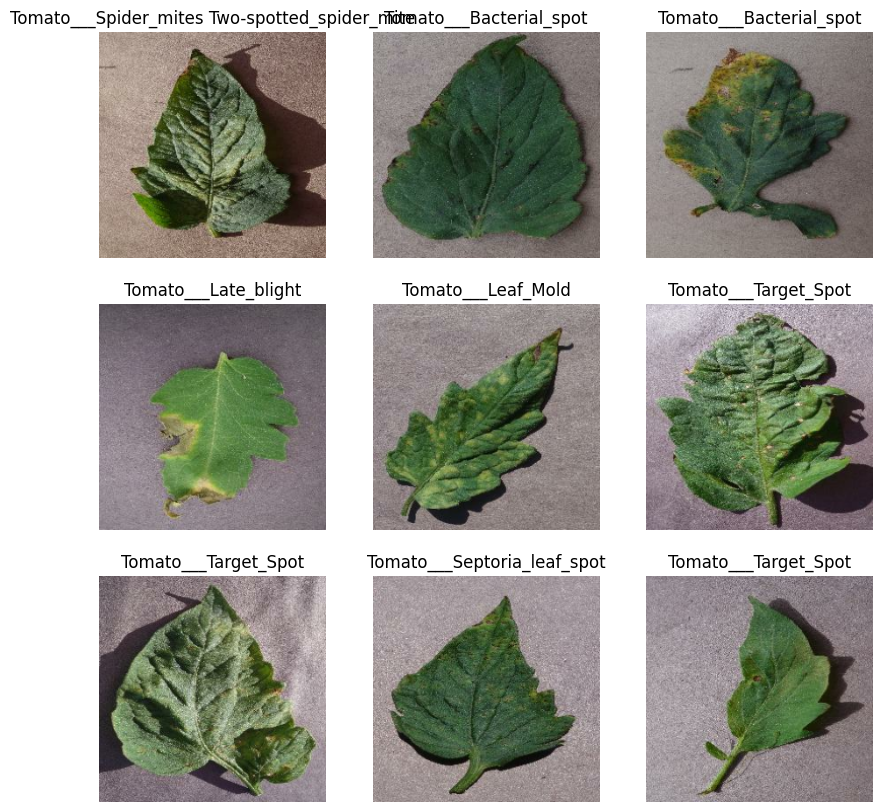

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.9457604


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**<h1> Model 1 (InceptionV3)</h1>**

In [15]:
IMAGE_SIZE = [224,224]
IMAGE_SIZE

[224, 224]

In [16]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [17]:
for layer in inception.layers:
    layer.trainable = False

In [18]:
folders = glob('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset/train/*')

In [19]:
x = Flatten()(inception.output)

In [20]:
prediction = Dense(len(folders), activation='softmax')(x)
model_INCEPTION_V3 = Model(inputs=inception.input, outputs=prediction)

In [21]:
model_INCEPTION_V3.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,314,794 (85.12 MB)

 Trainable params: 512,010 (1.95 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [22]:
model_INCEPTION_V3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 10000 images belonging to 10 classes.


In [25]:
valid_set = valid_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset/valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 10 classes.


In [ ]:
model_INCEPTION_V3.fit(training_set,validation_data=valid_set,validation_batch_size=64,epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1899s 6s/step - accuracy: 0.5651 - loss: 5.0624 - val_accuracy: 0.7390 - val_loss: 2.6867
Epoch 2/10
183/313 ━━━━━━━━━━━━━━━━━━━━ 8:42 4s/step - accuracy: 0.8424 - loss: 1.0575

In [ ]:
model_INCEPTION_V3.save('/content/drive/MyDrive/tomato-disease-prediction/model_INCEPTION_V3_best.h5')

In [ ]:
score_train = model_INCEPTION_V3.evaluate(training_set, verbose=2)
accuracy_train = 100*score_train[1]

print('Train accuracy = %.4f%% ' % accuracy_train)

In [ ]:
score_val = model_INCEPTION_V3.evaluate(valid_set, verbose=2)
accuracy_val = 100*score_val[1]

print('Validate accuracy = %.4f%% ' % accuracy_val)

for InceptionV3
574/574 - 95s - loss: 0.6120 - accuracy: 0.9460
Train accuracy = 94.5980%
144/144 - 24s - loss: 4.1287 - accuracy: 0.8198
Validate accuracy = 81.9847%

**<h1>Model 2 (VGG19)</h1>**

In [ ]:
IMAGE_SIZE = [224,224]
IMAGE_SIZE

In [ ]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg19.layers:
    layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset/train/*')

In [ ]:
x = Flatten()(vgg19.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

model_VGG19 = Model(inputs=vgg19.input, outputs=prediction)

In [ ]:
model_VGG19.summary()

In [ ]:
model_VGG19.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

In [ ]:
valid_set = valid_datagen.flow_from_directory('/content/drive/MyDrive/tomato-disease-prediction/unzipped_data/New_Plant_Diseases_Dataset/valid',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

In [ ]:
model_VGG19.fit(training_set,validation_data=valid_set,validation_batch_size=64,epochs=10)

NameError: name 'model_VGG19' is not defined

In [ ]:
model_VGG19.save('/content/drive/MyDrive/tomato-disease-prediction/model_VGG19_best.h5')

In [ ]:
score_train = model_VGG19.evaluate(training_set, verbose=2)
accuracy_train = 100*score_train[1]
print('Train accuracy = %.4f%% ' % accuracy_train)

score_val = model_VGG19.evaluate(valid_set, verbose=2)
accuracy_val = 100*score_val[1]
print('Validate accuracy = %.4f%% ' % accuracy_val)

for VGG19
574/574 - 155s - loss: 0.0275 - accuracy: 0.9916
Train accuracy = 99.8801%
144/144 - 39s - loss: 0.3669 - accuracy: 0.8992
Validate accuracy = 92.1047%